In [2]:
!pip install gymnasium[mujoco]
!pip install stable-baselines3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.4/6.4 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 958.1/958.1 kB 65.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 5.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment Ant-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment Ant-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment Ant-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment Ant-v4 is out of date. You should consider upgrading to version `v5`.
  logger.deprecation(
/usr/local/lib/python3.10/dist-packages/gymnasium/envs/registration.py:517: DeprecationWarning: WARN: The environment Ant-v4 is out of date. You should consider

Iteration 0: Reward Mean = 998.61, Std = 0.80, Slope = nan
Current Policy Architecture:
  - pi: [64, 64]
  - vf: [64, 64]
Iteration 1: Reward Mean = 998.40, Std = 3.94, Slope = nan
Current Policy Architecture:
  - pi: [64, 64]
  - vf: [64, 64]
Iteration 2: Reward Mean = 996.74, Std = 3.45, Slope = nan
Current Policy Architecture:
  - pi: [64, 64]
  - vf: [64, 64]
Iteration 3: Reward Mean = 997.69, Std = 1.73, Slope = nan
Current Policy Architecture:
  - pi: [64, 64]
  - vf: [64, 64]
Iteration 4: Reward Mean = 999.31, Std = 3.05, Slope = -0.1219
Current Policy Architecture:
  - pi: [64, 64]
  - vf: [64, 64]
Iteration 4: Modifying network architecture
Iteration 5: Reward Mean = 1001.78, Std = 2.50, Slope = nan
Current Policy Architecture:
  - pi: [60, 57]
  - vf: [64, 64]
Iteration 6: Reward Mean = 1001.67, Std = 1.59, Slope = nan
Current Policy Architecture:
  - pi: [60, 57]
  - vf: [64, 64]
Iteration 7: Reward Mean = 1000.67, Std = 3.96, Slope = nan
Current Policy Architecture:
  - pi:

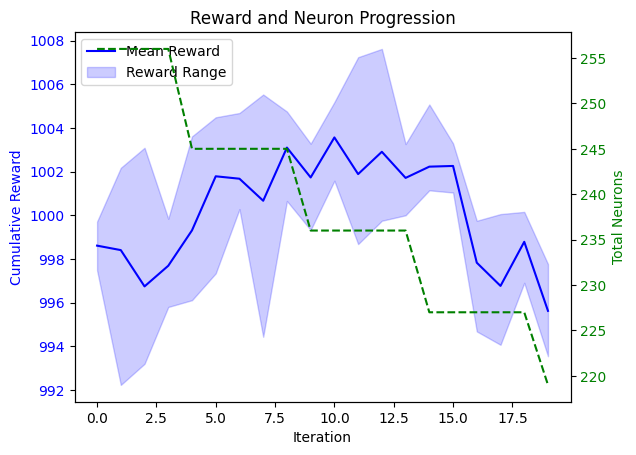

In [3]:
import gymnasium as gym
import numpy as np
from multiprocessing import Process, Queue
from stable_baselines3 import PPO
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os

os.environ["MUJOCO_GL"] = "egl"

def evaluate_policy(env, model, num_eval_episodes=5, num_eval_steps_per_episode=1000):
    total_rewards = []
    for _ in range(num_eval_episodes):
        observation, info = env.reset()
        episode_reward = 0
        for _ in range(num_eval_steps_per_episode):
            action, _ = model.predict(observation, deterministic=True)
            observation, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward
            if terminated or truncated:
                break
        total_rewards.append(episode_reward)
    return np.mean(total_rewards)

def follower_process(env_name, queue, weight_queue, worker_id, num_iterations, device):
    """
    各workerプロセスでPPOを学習し、評価結果をleaderに送信。
    """
    env = gym.make(env_name, render_mode='rgb_array')
    policy_kwargs = dict(activation_fn=torch.nn.ReLU, net_arch=dict(pi=[64, 64], vf=[64, 64]))
    model = PPO("MlpPolicy", env, verbose=0, policy_kwargs=policy_kwargs, device=device)

    for iteration in range(num_iterations):
        model.learn(total_timesteps=1000)

        # 評価
        total_reward = evaluate_policy(env, model)

        # 現在のポリシー重みとアーキテクチャを送信
        queue.put((worker_id, iteration, total_reward, policy_kwargs, model.policy.state_dict()))

        # Leaderから新しい重みとアーキテクチャを受信
        new_weights, new_arch = weight_queue.get()
        model.policy.load_state_dict(new_weights)
        policy_kwargs["net_arch"] = new_arch

    env.close()

def leader_process(queue, weight_queue, num_workers, num_iterations, ema_window, dropout_rates, slope_threshold, device):
    """
    leaderが評価結果を収集し、収益を平滑化、傾きを計算、必要ならネットワークを再構築。
    """
    all_rewards = []
    ema_rewards = []
    rewards_per_worker = [[] for _ in range(num_workers)]  # 各workerの収益記録
    neuron_counts = []  # ニューロン数の推移
    iteration_list = []

    for iteration in range(num_iterations):
        results = []
        weights = []
        policy_arch = None
        iteration_list.append(iteration)

        # 各workerから結果を収集
        for _ in range(num_workers):
            worker_id, iter_id, reward, policy_kwargs, policy_weight = queue.get()
            results.append(reward)
            weights.append(policy_weight)
            rewards_per_worker[worker_id].append(reward)
            policy_arch = policy_kwargs["net_arch"]

        # 統計情報を表示
        mean_reward = np.mean(results)
        std_reward = np.std(results)
        all_rewards.append(mean_reward)

        # EMAを更新
        alpha = 2 / (ema_window + 1)
        if ema_rewards:
            ema_reward = alpha * mean_reward + (1 - alpha) * ema_rewards[-1]
        else:
            ema_reward = mean_reward
        ema_rewards.append(ema_reward)

        # 傾きを計算
        if len(ema_rewards) > ema_window:
            slope = (np.polyfit(iteration_list, ema_rewards, deg=1))[0]
        else:
            slope = float("nan")

        # 出力: 統計情報
        print(f"Iteration {iteration}: Reward Mean = {mean_reward:.2f}, Std = {std_reward:.2f}, Slope = {slope:.4f}")

        # 出力: アーキテクチャ情報
        print("Current Policy Architecture:")
        for layer, shape in policy_arch.items():
            print(f"  - {layer}: {shape}")

        # ネットワークの修正条件
        if slope < slope_threshold and len(weights) > 0:
            print(f"Iteration {iteration}: Modifying network architecture")
            avg_weights = average_weights(weights)
            modified_arch, modified_weights = modify_network(avg_weights, policy_arch, dropout_rates, device)
            iteration_list = []
            ema_rewards = []
        else:
            modified_arch = policy_arch
            modified_weights = average_weights(weights)

        # ニューロン数を記録
        total_neurons = sum(sum(units) for units in modified_arch.values())
        neuron_counts.append(total_neurons)

        # 重みと新しいアーキテクチャを各workerに送信
        for _ in range(num_workers):
            weight_queue.put((modified_weights, modified_arch))

    # 収益のグラフを表示
    iterations = np.arange(num_iterations)
    rewards_per_worker = np.array(rewards_per_worker)

    fig, ax1 = plt.subplots()

    # 収益プロット
    ax1.plot(iterations, all_rewards, label="Mean Reward", color="blue")
    # ax1.plot(iterations, ema_rewards, label="EMA Reward", color="red")
    ax1.fill_between(
        iterations,
        rewards_per_worker.min(axis=0),
        rewards_per_worker.max(axis=0),
        color="blue",
        alpha=0.2,
        label="Reward Range",
    )
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Cumulative Reward", color="blue")
    ax1.tick_params(axis="y", labelcolor="blue")
    ax1.legend(loc="upper left")

    # ニューロン数プロット
    ax2 = ax1.twinx()
    ax2.plot(iterations, neuron_counts, label="Total Neurons", color="green", linestyle="--")
    ax2.set_ylabel("Total Neurons", color="green")
    ax2.tick_params(axis="y", labelcolor="green")
    # ax2.legend(loc="upper right")

    plt.title("Reward and Neuron Progression")
    plt.show()

def modify_network(weights, arch, dropout_rates, device):
    """
    ネットワークのアーキテクチャを修正し、指定割合のニューロンを削除。
    """
    new_arch = {}
    modified_weights = {}

    for layer_type, layers in arch.items():  # layer_type は 'pi' または 'vf'
        new_arch[layer_type] = []
        for idx, units in enumerate(layers):
            # 各層のドロップアウト率を取得
            dropout_rate = dropout_rates[layer_type][idx]
            new_units = int(units * (1 - dropout_rate))  # 削除後のユニット数
            new_arch[layer_type].append(new_units)

        # 重みを修正
        for key, value in weights.items():
            if layer_type in key and "weight" in key:
                # 各層の削除されたニューロンに対応する重みを除外
                layer_idx = int(key.split(".")[1])  # 層のインデックスを取得
                if layer_idx < len(layers):
                    new_units = new_arch[layer_type][layer_idx]
                    modified_weights[key] = value[:new_units, :new_units].to(device)
                else:
                    modified_weights[key] = value.to(device)
            else:
                modified_weights[key] = value.to(device)

    return new_arch, modified_weights


def average_weights(weights_list):
    """
    重みを平均化する。
    """
    avg_weights = {}
    for key in weights_list[0].keys():
        avg_weights[key] = torch.stack([weights[key] for weights in weights_list]).mean(dim=0)
    return avg_weights

if __name__ == "__main__":
    ENV_NAME = "Ant-v4"
    NUM_WORKERS = 5
    NUM_ITERATIONS = 20
    EMA_WINDOW = 4  # 平滑化するIteration
    DROPOUT_RATES = {
    "pi": [0.05, 0.1],  # Actorネットワーク各層のドロップアウト率
    "vf": [0.0, 0.0]   # Criticネットワーク各層のドロップアウト率
    }
    SLOPE_THRESHOLD = 0.1  # ネットワーク修正の閾値
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

    result_queue = Queue()
    weight_queue = Queue()

    # Workerプロセスの作成
    workers = []
    for worker_id in range(NUM_WORKERS):
        p = Process(target=follower_process, args=(ENV_NAME, result_queue, weight_queue, worker_id, NUM_ITERATIONS, DEVICE))
        workers.append(p)
        p.start()

    # Leaderプロセスの実行
    leader_process(result_queue, weight_queue, NUM_WORKERS, NUM_ITERATIONS, EMA_WINDOW, DROPOUT_RATES, SLOPE_THRESHOLD, DEVICE)

    # Workerプロセスの終了を待つ
    for p in workers:
        p.join()
